In [20]:
import os
import sys
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import pandas as pd

from icecream import ic, colorize as ic_colorize, argumentToString

sns.set_style('white')
sns.set_theme(rc={"legend.facecolor": "w"})

mpl.rcParams["pdf.fonttype"] = 42

os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# Register a function to summarize numpy array
@argumentToString.register
def argumentToString_ndarray(obj: np.ndarray):
  return (
    f"ndarray, shape={obj.shape}, dtype={obj.dtype}, "
    f"min={obj.min()}, max={obj.max()}"
  )


ic.configureOutput(prefix="⚡ ")
ic.configureOutput(outputFunction=lambda s: print(ic_colorize(s)))

np.set_printoptions(threshold=5, precision=2, edgeitems=2, linewidth=200, suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from admice.dataload import session_from_mouse_from_matfile, load_mice_from_mat 

In [23]:
data_root = os.path.expanduser("~/data/tedho_ad_mice/")

def jdr(fname:str) -> str:
  return os.path.join(data_root, fname)

sess_ctrl = load_mice_from_mat(jdr("workspace_28-Jun-2024_control_mice_2p_data_for_dan.v7.mat"), "controlmice", "control")
sess_young = load_mice_from_mat(jdr("workspace_28-Jun-2024_young3xtg_mice_2p_data_for_dan.v7.mat"), "young3xtgmice", "young_3xtg")
sess_old = load_mice_from_mat(jdr("workspace_28-Jun-2024_old3xtg_mice_2p_data_for_dan.v7.mat"), "old3xtgmice", "old_3xtg")

bad_mouse_ids = [16, 22, 52]

# filter out 3 bad mice Ted mentioned in Slack
sess_young = [mouse for mouse in sess_young if mouse.mouse_id not in bad_mouse_ids]
sess_old = [mouse for mouse in sess_old if mouse.mouse_id not in bad_mouse_ids]

ic([mouse.mouse_id for mouse in sess_ctrl]);
ic([mouse.mouse_id for mouse in sess_young]);
ic([mouse.mouse_id for mouse in sess_old]);

⚡ [mouse.mouse_id for mouse in sess_ctrl]: [27, 15, 17, 25, 33, 34, 35]
⚡ [mouse.mouse_id for mouse in sess_young]: [18, 19, 20, 23, 24]
⚡ [mouse.mouse_id for mouse in sess_old]: [28, 29, 30, 31, 32]


### Initial exploration: wide window LDA to get the axes


In [4]:
from admice.eventlda import FilteringStrategy, NeuronSamplingStrategy

filt_strat_fit = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23, window_buffer_pre = 2, reduce_mode_pre = "mean", 
  window_width_post = 23, window_buffer_post = 2, reduce_mode_post = "mean")
filt_strat_project = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23, window_buffer_pre = 4, reduce_mode_pre = "mean", 
  window_width_post = 4, window_buffer_post = 0, reduce_mode_post = "mean")
samp_strat = NeuronSamplingStrategy(mode="random", n_neurons = 50)

In [5]:
# filter whole dataset
sess = sess_ctrl[0]
filt_nrt = filt_strat_project.filter_sliding(sess.data_nrt)

⚡ np.count_nonzero(np.isnan(filt_tn)): 0


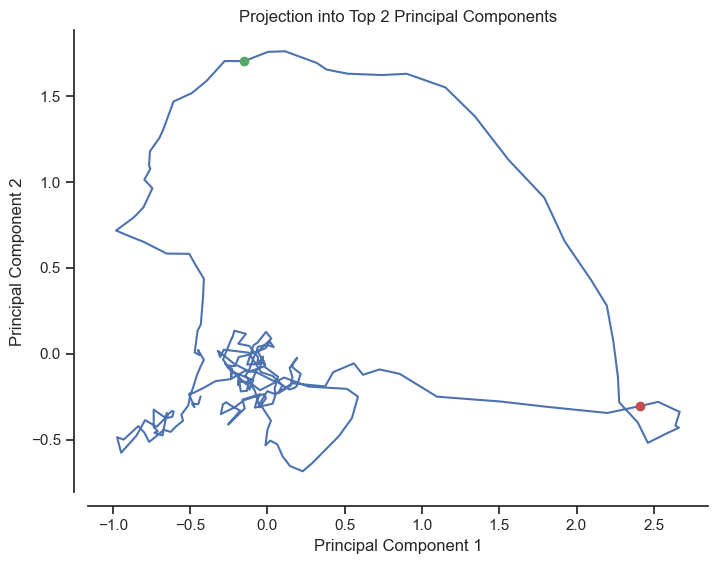

In [9]:
from sklearn.decomposition import PCA

# Step 1: Reshape filt_nrt to (N, R*T)
N, R, T = filt_nrt.shape

filt_tn = np.mean(filt_nrt, axis=1).T
filt_tn = filt_tn[~np.isnan(filt_tn).any(axis=1), :]

ic(np.count_nonzero(np.isnan(filt_tn)))

# Step 2: Apply PCA to project the data into the top 2 principal components
pca = PCA(n_components=3)
proj_tk = pca.fit_transform(filt_tn)  # Shape becomes (R*T, 2)

# Step 3: Plot the results
tone_ind = sess.tone_ind
puff_ind = sess.puff_ind

sns.set_style('ticks')
plt.figure(figsize=(8, 6))
plt.plot(proj_tk[:, 0], proj_tk[:, 1])
plt.plot(proj_tk[tone_ind, 0], proj_tk[tone_ind, 1], marker='o', color='r')
plt.plot(proj_tk[puff_ind, 0], proj_tk[puff_ind, 1], marker='o', color='g')

plt.title('Projection into Top 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(False)
sns.despine(offset=10)
plt.show()

### v1 : using two separate LDA classifiers (tone vs. pre-tone, puff vs. tone)


In [127]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut, cross_val_score

seed = 1
pos_nr_tone, neg_nr_tone = filt_strat_fit.extract_pos_neg_data_at_event(
  sess.data_nrt, evaluate_ind=sess.tone_ind, neg_before_ind=sess.tone_ind, seed=seed
)
pos_nr_puff, neg_nr_puff = filt_strat_fit.extract_pos_neg_data_at_event(
  sess.data_nrt, evaluate_ind=sess.puff_ind, neg_before_ind=sess.tone_ind, seed=seed
)

_, R, T = sess.data_nrt.shape

n_samples = 10
proj_tone_crt = np.zeros((n_samples, R, T))
proj_puff_crt = np.zeros((n_samples, R, T))

R_pos = pos_nr_tone.shape[1]
R_neg = neg_nr_tone.shape[1]
y = np.hstack((np.ones(R_pos), np.zeros(R_neg)))  # 1 for positive, 0 for negative

def orthogonalize(A, B):
    # normalize rows of A 
    A = A / np.linalg.norm(A, axis=1, keepdims=True) 
    B = B / np.linalg.norm(B, axis=1, keepdims=True)

    # Compute the dot products
    dot_product = np.einsum('ij,ij->i', A, B)
    
    # Compute the projection of B onto A
    projection = dot_product[:, np.newaxis] * A
    
    # Subtract the projection from B to orthogonalize
    B_orth = B - projection
    
    # Normalize the orthogonalized B
    B_orth = B_orth / np.linalg.norm(B_orth, axis=1, keepdims=True)
    
    return A, B_orth


for c in range(n_samples):
  # sample neurons
  n_idx = samp_strat.get_sample_inds(n_neurons_total=sess.n_neurons, seed=c)
  pos_nr_tone_sampled = pos_nr_tone[n_idx, :]
  pos_nr_puff_sampled = pos_nr_puff[n_idx, :]
  neg_nr_tone_sampled = neg_nr_tone[n_idx, :]
  neg_nr_puff_sampled = neg_nr_puff[n_idx, :]

  # assemble LDA inputs
  X_tone = np.hstack((pos_nr_tone_sampled, neg_nr_tone_sampled)).T  # Shape (R_pos + R_neg, N)
  # X_puff = np.hstack((pos_nr_puff_sampled, neg_nr_puff_sampled)).T  # Shape (R_pos + R_neg, N)
  X_puff = np.hstack((pos_nr_puff_sampled, pos_nr_tone_sampled)).T  # Shape (R_pos + R_neg, N)

  lda_tone = LinearDiscriminantAnalysis()
  lda_puff = LinearDiscriminantAnalysis()
  loo = LeaveOneOut()

  N_samp = samp_strat.n_neurons 
  cv_coef_tone = np.zeros((R_pos + R_neg, N_samp))
  cv_coef_puff = np.zeros((R_pos + R_neg, N_samp))

  # loop over folds, store cv transforms for each trials
  for train_index, test_index in loo.split(X):
    # fit tone vs. pre LDA 
    X_train, X_test = X_tone[train_index], X_tone[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lda_tone.fit(X_train, y_train)
    
    # fit puff vs. pre LDA 
    X_train, X_test = X_puff[train_index], X_puff[test_index]
    lda_puff.fit(X_train, y_train)

    cv_coef_tone[test_index, :] = lda_tone.coef_
    cv_coef_puff[test_index, :] = lda_puff.coef_

  # keep only the transforms for positive trials
  cv_coef_tone = cv_coef_tone[y == 1, :]
  cv_coef_puff = cv_coef_puff[y == 1, :]

  # orthogonalize puff loadings against tone loadings
  cv_coef_tone, cv_coef_puff = orthogonalize(cv_coef_tone, cv_coef_puff)

  # project each trial individually through the scalings
  in_nrt = filt_nrt[n_idx, :, :]
  in_nrt -= np.nanmean(in_nrt[:, :, :sess.tone_ind], axis=2, keepdims=True)
  proj_tone_crt[c] = np.einsum('nrt,rn->rt', in_nrt, cv_coef_tone)
  proj_puff_crt[c] = np.einsum('nrt,rn->rt', in_nrt, cv_coef_puff)

In [149]:
lda.scalings_.shape

(50, 2)

In [111]:
np.dot(cv_coef_tone[0, :], cv_coef_puff[0, :])

np.float64(5.551115123125783e-17)

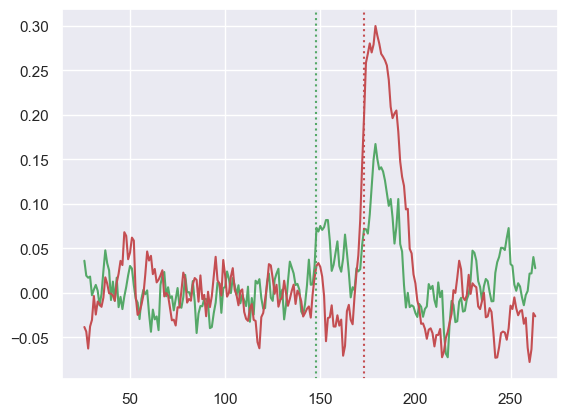

In [128]:
plt.plot(np.mean(proj_tone_crt, axis=(0, 1)), color='g')
plt.plot(np.mean(proj_puff_crt, axis=(0, 1)), color='r')
plt.axvline(sess.tone_ind, color='g', linestyle='dotted')
plt.axvline(sess.puff_ind, color='r', linestyle='dotted')

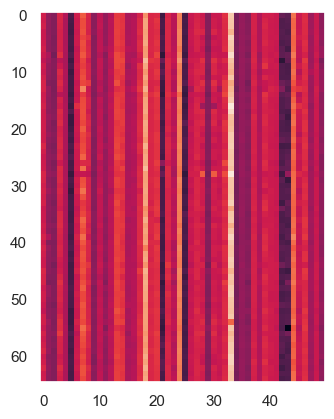

In [34]:
plt.imshow(cv_scalings)
plt.grid(False)

### `reconfigure` utility


In [15]:
import itertools
import math

def generate_combinations_and_divisions(known_shapes):
  all_combinations = {}

  known_shapes = {''.join(sorted(key)): value for key, value in known_shapes.items()}

  if any(len(key) != len(set(key)) for key in known_shapes):
    raise ValueError("Keys in known_shapes may not duplicate characters")

  # Generate all possible subsets of keys
  for r in range(1, len(known_shapes) + 1):
    for subset in itertools.combinations(known_shapes.keys(), r):
        # Concatenate keys and calculate the product of their values
        concatenated_key = ''.join(subset)
        # Get the unique sorted characters
        concatenated_key_sorted = ''.join(sorted(set(concatenated_key)))

        # Only store the product if all characters in concatenated_key are unique
        if len(concatenated_key) == len(concatenated_key_sorted):
          product = math.prod(known_shapes[key] for key in subset)
          if concatenated_key_sorted not in all_combinations:
            all_combinations[concatenated_key_sorted] = product

        # Now, consider division by any key within the subset
        for key in subset:
          remaining_key = concatenated_key_sorted.replace(key, '', 1)

          if len(remaining_key) == 0:
            continue

          # Sort the unique characters for the key we're dividing by
          unique_key_sorted = ''.join(sorted(set(key)))
          
          # If all characters in unique_key_sorted are in concatenated_key_sorted
          # then we can compute the shape of the remaining characters via division
          if all(char in concatenated_key_sorted for char in unique_key_sorted):
            division_result = all_combinations.get(concatenated_key_sorted, 1) / known_shapes[key]
            if division_result != int(division_result):
              raise ValueError(f"Could not evenly divide {key}={known_shapes[key]} into {concatenated_key_sorted} = {all_combinations[concatenated_key_sorted]}")
            division_result = int(division_result)
            if remaining_key in all_combinations:
              # Ensure we store the maximum value (if required)
              if all_combinations[remaining_key] != division_result:
                raise ValueError(f"Reached conflicting value for {remaining_key}={all_combinations[remaining_key]} != {division_result} dividing {key}={known_shapes[key]} into {concatenated_key_sorted} = {all_combinations[concatenated_key_sorted]}")
            else:
              all_combinations[remaining_key] = division_result

  # Sort keys by length first, then alphabetically
  sorted_keys = sorted(all_combinations.keys(), key=lambda x: (len(x), x))
  
  # Create a new dictionary with sorted keys
  all_combinations = {key: all_combinations[key] for key in sorted_keys}
  return all_combinations


In [20]:
# Example usage
known_shapes = {'de': 4, 'e': 2}
print(generate_combinations_and_divisions(known_shapes))

known_shapes = {'abc': 6, 'ab': 2, 'a': 1}
print(generate_combinations_and_divisions(known_shapes))

# Test Case 1: Basic Case with No Duplicates
known_shapes = {'a': 1, 'b': 2, 'c': 3}
print(generate_combinations_and_divisions(known_shapes))

# Test Case 2: Case with Division
known_shapes = {'de': 4, 'e': 2}
print(generate_combinations_and_divisions(known_shapes))

known_shapes = {'abc': 6, 'ab': 2, 'b': 2}
print(generate_combinations_and_divisions(known_shapes))

known_shapes = {'ab': 4, 'a': 2}
print(generate_combinations_and_divisions(known_shapes))

# Test Case 5: Case with Keys That Are Subsets of Others
known_shapes = {'xyz': 24, 'xy': 8, 'z': 3}
print(generate_combinations_and_divisions(known_shapes))

# Test Case 6: Complex Case with Overlapping Keys
known_shapes = {'abcd': 24, 'ab': 4, 'cd': 6}
print(generate_combinations_and_divisions(known_shapes));


{'d': 2, 'e': 2, 'de': 4}
{'a': 1, 'b': 2, 'c': 3, 'ab': 2, 'bc': 6, 'abc': 6}
{'a': 1, 'b': 2, 'c': 3, 'ab': 2, 'ac': 3, 'bc': 6, 'abc': 6}
{'d': 2, 'e': 2, 'de': 4}
{'a': 1, 'b': 2, 'c': 3, 'ab': 2, 'ac': 3, 'abc': 6}
{'a': 2, 'b': 2, 'ab': 4}
{'z': 3, 'xy': 8, 'xyz': 24}
{'ab': 4, 'cd': 6, 'abcd': 24}


In [36]:
import numpy as np

def find_perm_order(input_axes: tuple[str], output_axes: tuple[str]) -> tuple[list[bool], list[int]]:
  in_req_split = [False] * len(input_axes)
  can_perm_out_axis = []
  perm_order = []
  current_flat_order = ''
  for out_part in output_axes:
    # loop over input_axes and try to build each out_part using concatenated elements of input_axes
    for i, in_part in enumerate(input_axes):
      if i not in perm_order: 
        if out_part.startswith(in_part):
          perm_order.append(i)
          out_part = out_part[len(in_part):]
          if len(out_part) == 0:
            can_perm_out_axis.append(True)

    if len(out_part) != 0:
      # didn't find a way to build out_part
      can_perm_out_axis.append(False)

      # figure out which input_axes would need to be split up 

  
  

  return can_perm_out_axis, perm_order

in_tuple = ('ab', 'cd')
out_tuple = ('cd', 'ab')
ic(find_perm_order(in_tuple, out_tuple))

in_tuple = ('ab', 'cd')
out_tuple = ('d', 'c', 'ba')
ic(find_perm_order(in_tuple, out_tuple))

in_tuple = ('a', 'b', 'c', 'd')
out_tuple = ('cd', 'ab')
ic(find_perm_order(in_tuple, out_tuple))

in_tuple = ('ab', 'cd')
out_tuple = ('a', 'b', 'cd')
ic(find_perm_order(in_tuple, out_tuple))

⚡ find_perm_order(in_tuple, out_tuple): ([True, True], [1, 0])
⚡ find_perm_order(in_tuple, out_tuple): ([False, False, False], [])
⚡ find_perm_order(in_tuple, out_tuple): ([True, True], [2, 3, 0, 1])
⚡ find_perm_order(in_tuple, out_tuple): ([False, False, True], [1])


([False, False, True], [1])

In [ ]:

def reconfigure(array, input_axes, output_axes, **kwargs):
  """
  Reconfigures an array by reshaping and transposing its axes based on the given input and output axis labels.
  
  Parameters:
  - array: np.ndarray, the input array to be reconfigured.
  - input_axes: tuple of str, axis labels of the input array.
  - output_axes: tuple of str, desired axis labels for the output array.
  - kwargs: optional, specify the size of axes if they need to be split.
  
  Returns:
  - reconfigured_array: np.ndarray, the array with reconfigured axes.
  """

  # determine the permutation order
  in_flat_order = ''.join(key for key in input_axes)
  out_flat_order = ''.join(key for key in output_axes)

  # Check that both a and b have no duplicate characters
  if len(in_flat_order) != len(set(in_flat_order)):
      raise ValueError("input_axes contain duplicate characters.")
  
  if len(out_flat_order) != len(set(out_flat_order)):
      raise ValueError("output_axes contain duplicate characters.")
  
  # Check that b is a permutation of a
  if sorted(in_flat_order) != sorted(out_flat_order):
      raise ValueError("output_axes must contain all characters in input_axes.")

  # Attempt to find a permutation of input_axes such that the flat ordering that matches that of output_axes
  can_permute, perm_order = find_perm_order(input_axes, output_axes)

  if not can_permute:
    # no valid permutation found, just split 
 
        # Handle case where no valid permutation is found
        # reshape it into its constituent 
        for 
        array = 
  if current_flat_order != out_flat_order:
      pass  # Handle case where no valid permutation is found

  
  # Determine the permutation order
  perm_order = [in_flat_order.index(scalar_axis) for scalar_axis in out_sort_order]

  perm_order = [input_axes.index(part) for axis in output_axes for part in axis if part in input_axes]

  # assemble known shapes from input and kwargs
  input_shape = dict(zip(input_axes, array.shape))
  conflicting_keys = {key for key in input_shape if key in kwargs and input_shape[key] != kwargs[key]}
  if conflicting_keys:
    raise ValueError(f"Conflicting values for axis lengths: {conflicting_keys}")

  known_shapes = {**input_shape, **kwargs}
  print(known_shapes)

  # inflate with combinations and divisions
  known_shapes = generate_combinations_and_divisions(known_shapes)
  print(known_shapes)

  # Step 3: Determine the new shape
  new_shape = []
  for axis in output_axes:
    if axis in known_shapes:
      new_shape.append(known_shapes[axis])
    else:
      raise ValueError(f"Could not determine size of '{axis}' from input_axes and kwargs.")
  
  # Step 5: Reshape and transpose the array
  transposed_array = np.transpose(array, perm_order)
  reconfigured_array = transposed_array.reshape(new_shape)
  
  return reconfigured_array

# Example usage
N, R, T = 4, 3, 5
array = np.random.rand(N, R, T)

# Reconfigure from (N, R, T) to (RT, N)
reordered_array = reconfigure(array, ('N', 'R', 'T'), ('RT', 'N'))
print("Reordered array shape:", reordered_array.shape)

# Reconfigure back from (RT, N) to (N, R, T)
array_recovered = reconfigure(reordered_array, ('RT', 'N'), ('N', 'R', 'T'), R=R)
print("Recovered array shape:", array_recovered.shape)

### v2 : using a single multiclass LDA classifier (pre-tone, tone, puff)


In [8]:
from admice.ldaproj import project_lda_pufftone

proj_crtk = project_lda_pufftone(sess, filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = 10)

Running neuron samples: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s]


In [14]:
a = np.reshape(np.arange(2*3*4), (6, 4))
with np.printoptions(threshold=np.inf):
  print(a)
  print(np.reshape(a, (2, 3, 4)))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]]
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [9]:
from admice.ldaproj import project_lda_pufftone_parallel_samples

sess = sess_ctrl[0]
proj_crtk = project_lda_pufftone_parallel_samples(sess, filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = 10, parallel=False)

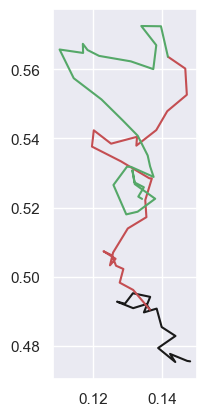

In [10]:
offset = filt_strat_project.window_width_post
tone_ind = sess.tone_ind
puff_ind = sess.puff_ind
start_ind = int(tone_ind - offset - sess.fps // 2)

proj_tk = np.mean(proj_crtk, axis=(0, 1))
# proj_tk = proj_tk - np.nanmean(proj_tk[start_ind:tone_ind - offset], axis=0, keepdims=True)

fig, ax = plt.subplots(1, 1)
ax.plot(proj_tk[start_ind:tone_ind-offset+1, 0], proj_tk[start_ind:tone_ind-offset+1, 1], color='k')
ax.plot(proj_tk[tone_ind-offset:puff_ind-offset+1, 0], proj_tk[tone_ind-offset:puff_ind-offset+1, 1], color='r')
ax.plot(proj_tk[puff_ind-offset:, 0], proj_tk[puff_ind-offset:, 1], color='g')
ax.set_aspect('equal', 'box')

In [38]:
# run on all ctrl mice

from admice.ldaproj import multimouse_pipeline_project_lda_pufftone 
res_ctrl = multimouse_pipeline_project_lda_pufftone(sess_ctrl, filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = 100)

(pid=39509) control 0 / 7: id 27 0:   0%|          | 0/700 [00:00<?, ?it/s]

In [40]:
proj_scrtk, time_vec, aligned_tone_ind = res_ctrl.averaged(over_samples=True, over_trials=True).get_time_aligned_proj()
proj_stk = np.squeeze(proj_scrtk, axis=(1, 2))
ic(proj_stk);

⚡ proj_stk: ndarray, shape=(7, 268, 2), dtype=float64, min=nan, max=nan


/var/folders/d1/sb1mvmvx4yd578kyyg2pm8zm0000gn/T/ipykernel_26616/618972592.py:6: RuntimeWarning: Mean of empty slice
  proj_tk = proj_tk - np.nanmean(proj_tk[start_ind:tone_ind - offset], axis=0, keepdims=True)


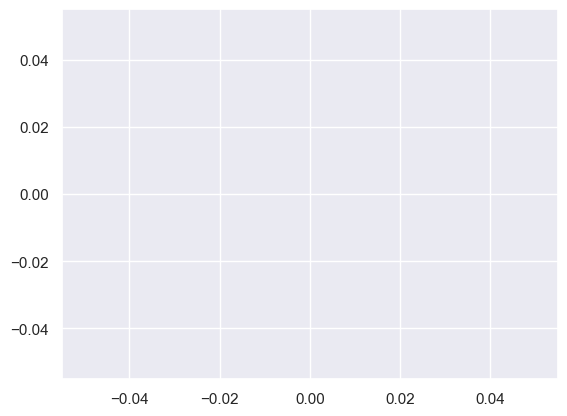

In [41]:
offset = filt_strat_project.window_width_post + filt_strat_project.window_buffer_post
start_ind = int(tone_ind - offset - sess.fps // 2)

proj_tk = np.mean(proj_stk, axis=0)
proj_tk = proj_stk[0]
proj_tk = proj_tk - np.nanmean(proj_tk[start_ind:tone_ind - offset], axis=0, keepdims=True)
tone_ind = sess.tone_ind
puff_ind = sess.puff_ind

fig, ax = plt.subplots(1, 1)
ax.plot(proj_tk[start_ind:tone_ind-offset+1, 0], proj_tk[start_ind:tone_ind-offset+1, 1], color='k')
ax.plot(proj_tk[tone_ind-offset:puff_ind-offset+1, 0], proj_tk[tone_ind-offset:puff_ind-offset+1, 1], color='r')
ax.plot(proj_tk[puff_ind-offset:, 0], proj_tk[puff_ind-offset:, 1], color='g')
# ax.set_aspect('equal', 'box')
ax.autoscale()

In [36]:
with np.printoptions(threshold=np.inf):
  print(proj_tk[:, 0])

[-0.35   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan -0.09 -0.09 -0.09 -0.1  -0.1  -0.09
 -0.09 -0.09 -0.08 -0.08 -0.08 -0.08 -0.08 -0.08 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.1  -0.1  -0.11 -0.11 -0.11 -0.12 -0.12 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13
 -0.13 -0.13 -0.13 -0.14 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.13 -0.12 -0.12 -0.11 -0.11 -0.1  -0.1  -0.1  -0.1  -0.1  -0.09 -0.09 -0.09 -0.09 -0.09 -0.08 -0.08 -0.08 -0.08 -0.07
 -0.06 -0.06 -0.06 -0.05 -0.05 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.03 -0.03 -0.03 -0.02 -0.02 -0.02 -0.02 -0.01 -0.01 -0.    0.    0.    0.    0.    0.    0.    0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.   -0.   -0.01 -0.01 -0.02 -0.02 -0.02 -0.02 -0.03 -0.03 -0.04 -0.04 -0.04 -0.04 -0.05 -0.05 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.05 -0.05 -0.05 -0.06
 -0.0

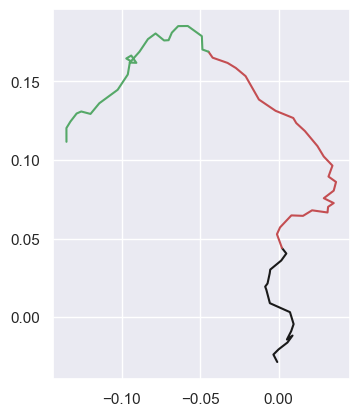

In [ ]:
offset = filt_strat_project.window_width_post + filt_strat_project.window_buffer_post
start_ind = int(tone_ind - offset - sess.fps // 2)

proj_tk = np.mean(proj_stk, axis=0)
proj_tk = proj_tk - np.nanmean(proj_tk[start_ind:tone_ind - offset], axis=0, keepdims=True)
tone_ind = sess.tone_ind
puff_ind = sess.puff_ind

fig, ax = plt.subplots(1, 1)
ax.plot(proj_tk[start_ind:tone_ind-offset+1, 0], proj_tk[start_ind:tone_ind-offset+1, 1], color='k')
ax.plot(proj_tk[tone_ind-offset:puff_ind-offset+1, 0], proj_tk[tone_ind-offset:puff_ind-offset+1, 1], color='r')
ax.plot(proj_tk[puff_ind-offset:, 0], proj_tk[puff_ind-offset:, 1], color='g')
ax.set_aspect('equal', 'box')

(np.float64(-0.0708855737669367),
 np.float64(0.4812364211774189),
 np.float64(-0.053167505334436906),
 np.float64(1.116517612023175))

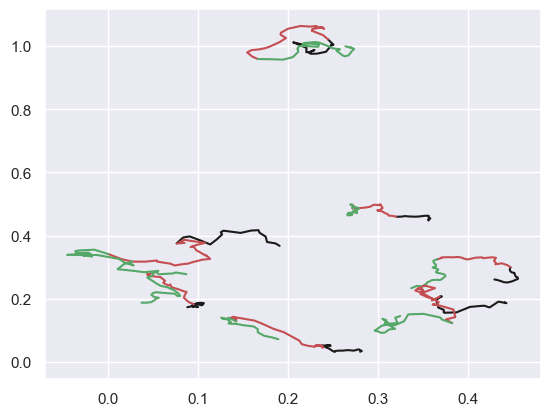

In [37]:
offset = filt_strat_project.window_width_post + filt_strat_project.window_buffer_post
start_ind = int(tone_ind - offset - sess.fps // 2)

tone_ind = aligned_tone_ind - offset
puff_ind = tone_ind + sess.puff_ind - sess.tone_ind

S = proj_stk.shape[0]
fig, ax = plt.subplots(1, 1)
for s in range(S):
  proj_tk = proj_stk[s]
  # proj_tk = proj_tk - np.nanmean(proj_tk[start_ind:tone_ind - offset], axis=0, keepdims=True)

  ax.plot(proj_tk[start_ind:tone_ind+1, 0], proj_tk[start_ind:tone_ind+1, 1], color='k')
  ax.plot(proj_tk[tone_ind:puff_ind+1, 0], proj_tk[tone_ind:puff_ind+1, 1], color='r')
  ax.plot(proj_tk[puff_ind:, 0], proj_tk[puff_ind:, 1], color='g')

ax.axis("tight")
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
# ax.set_aspect('equal', 'box')

### v3: trying orthonormalized 2 LDA again (debugging)


In [6]:
def orthonormalize_columns(matrix: np.ndarray) -> np.ndarray:
  # Normalize the first column
  v1 = matrix[:, 0]
  v1_normalized = v1 / np.linalg.norm(v1)

  # Orthogonalize the second column with respect to the first column
  v2 = matrix[:, 1]
  v2_proj_on_v1 = np.dot(v2, v1_normalized) * v1_normalized
  v2_orthogonal = v2 - v2_proj_on_v1

  # Normalize the orthogonalized second column
  v2_orthonormal = v2_orthogonal / np.linalg.norm(v2_orthogonal)

  # Combine the orthonormalized columns into a new matrix
  orthonormal_matrix = np.column_stack((v1_normalized, v2_orthonormal))

  return orthonormal_matrix

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneGroupOut

seed = 1
pos_nr_tone, neg_nr_tone = filt_strat_fit.extract_pos_neg_data_at_event(
  sess.data_nrt, evaluate_ind=sess.tone_ind, neg_before_ind=sess.tone_ind, seed=seed
)
pos_nr_puff, neg_nr_puff = filt_strat_fit.extract_pos_neg_data_at_event(
  sess.data_nrt, evaluate_ind=sess.puff_ind, neg_before_ind=sess.tone_ind, seed=seed
)

n_neurons, R, T = sess.data_nrt.shape
tone_ind = sess.tone_ind

# assemble data for LDA (pre-neuron sampling)
R_pos_tone = pos_nr_tone.shape[1]
R_pos_puff = pos_nr_puff.shape[1]
R_neg = neg_nr_tone.shape[1]
X = np.hstack(
  (neg_nr_tone, pos_nr_tone, pos_nr_puff)
).T  # Shape (R_neg + R_pos_tone + R_pos_puff, N)
y = np.hstack(
  (np.zeros(R_neg), np.ones(R_pos_tone), np.full(R_pos_puff, 2))
)  # 0 for pre-tone, 1 for post-tone, 2 for post-puff
r_groups = np.tile(np.arange(R), 3)  # trial groups for splits and cross-validation

# assemble full-trial data for passing thru transform()
# filt_nrt --> n(sampled) x rt
# Reorder the axes so that it becomes R x T x N
filt_nrt = filt_strat_project.filter_sliding(sess.data_nrt)
filt_rtn = np.transpose(filt_nrt, (1, 2, 0))

# Reshape to RT x N
# filt_rtn = filt_rtn - np.mean(filt_rtn[:, :tone_ind, :], axis=1, keepdims=True)
filt_rt_n = np.copy(filt_rtn).reshape(R * T, n_neurons)
filt_nan_mask_rt = np.isnan(filt_rt_n).any(axis=1)
filt_rt_n[filt_nan_mask_rt] = 0

K = 2  # dimensionality of LDA space
n_samples = 100
proj_crtk = np.zeros((n_samples, R, T, K))

lda_pre_v_tone = LinearDiscriminantAnalysis()
lda_tone_v_puff = LinearDiscriminantAnalysis()
logo = LeaveOneGroupOut()


for c in trange(n_samples, desc='neuron samples'):
  sample = c
  n_idx = samp_strat.get_sample_inds(n_neurons_total=n_neurons, seed=sample)
  X_sampled = X[:, n_idx]  # Shape (R_neg + R_pos_tone + R_pos_puff, N)

  mask = np.logical_or(y == 0, y == 1)
  X_pre_v_tone = X_sampled[mask]
  y_pre_v_tone = y[mask]
  r_groups_pre_v_tone = r_groups[mask]

  mask = np.logical_or(y == 1, y == 2)
  X_tone_v_puff = X_sampled[mask]
  y_tone_v_puff = y[mask]
  r_groups_tone_v_puff = r_groups[mask]

  # loop over folds, store cv transforms for each trials
  for (train_index_pre_v_tone, test_index_pre_v_tone), (
    train_index_tone_v_puff,
    test_index_tone_v_puff,
  ) in zip(
    logo.split(X_pre_v_tone, y_pre_v_tone, r_groups_pre_v_tone),
    logo.split(X_tone_v_puff, y_tone_v_puff, r_groups_tone_v_puff),
  ):
    # fit LDA x 2
    lda_pre_v_tone.fit(
      X_pre_v_tone[train_index_pre_v_tone], y_pre_v_tone[train_index_pre_v_tone]
    )
    lda_tone_v_puff.fit(
      X_tone_v_puff[train_index_tone_v_puff], y_tone_v_puff[train_index_tone_v_puff]
    )

    # N x 2
    # scalings = orthonormalize_columns(
    #   np.column_stack((lda_pre_v_tone.coef_.T, lda_tone_v_puff.coef_.T))
    # )
    scalings = orthonormalize_columns(
      np.column_stack((lda_pre_v_tone.scalings_, lda_tone_v_puff.scalings_))
    )

    # check whether we need to flip the axes to get the projected class centroids arranged in the right order
    # projected R x 2
    proj_pre_v_tone = X_pre_v_tone[train_index_pre_v_tone] @ scalings
    if np.mean(proj_pre_v_tone[y_pre_v_tone[train_index_pre_v_tone] == 0, 0]) > np.mean(
      proj_pre_v_tone[y_pre_v_tone[train_index_pre_v_tone] == 1, 0]
    ):
      scalings[:, 0] = -scalings[:, 0]
    proj_tone_v_puff = X_tone_v_puff[train_index_tone_v_puff] @ scalings
    if np.mean(proj_tone_v_puff[y_tone_v_puff[train_index_tone_v_puff] == 1, 1]) > np.mean(
      proj_tone_v_puff[y_tone_v_puff[train_index_tone_v_puff] == 2, 1]
    ):
      scalings[:, 1] = -scalings[:, 1]

    # list trial groups in the test set
    r_test_index = np.unique(r_groups[test_index_pre_v_tone])

    # transform the full corresponding test trials through the transforms
    rt_test_index = (r_test_index[:, None] + np.arange(T)).flatten()

    # RT x N @ N x 2
    out_rt_k = filt_rt_n[rt_test_index[:, None], n_idx] @ scalings
    # out_rt_k[:, 0] = out_rt_k[:, 0] - lda_pre_v_tone.xbar_ @ scalings[:, 0]
    # out_rt_k[:, 1] = out_rt_k[:, 1] - lda_tone_v_puff.xbar_ @ scalings[:, 1]

    # restore nans
    out_rt_k[filt_nan_mask_rt[rt_test_index]] = np.nan
    R_test = len(r_test_index)
    proj_crtk[c, r_test_index] = np.reshape(out_rt_k, (R_test, T, K))

neuron samples: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


In [44]:
lda_pre_v_tone.xbar_ @ scalings

(50,)

<StemContainer object of 3 artists>

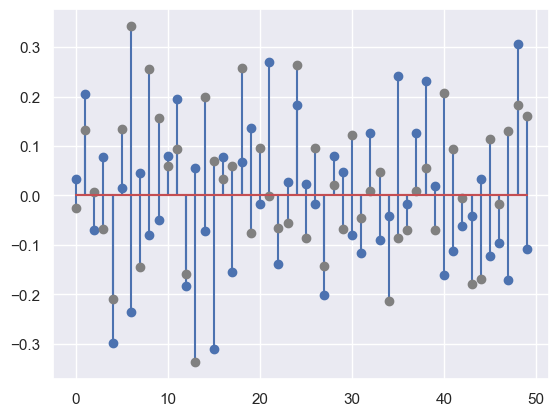

In [58]:
plt.stem(scalings[:,0])
plt.stem(scalings[:,1], markerfmt='grey')

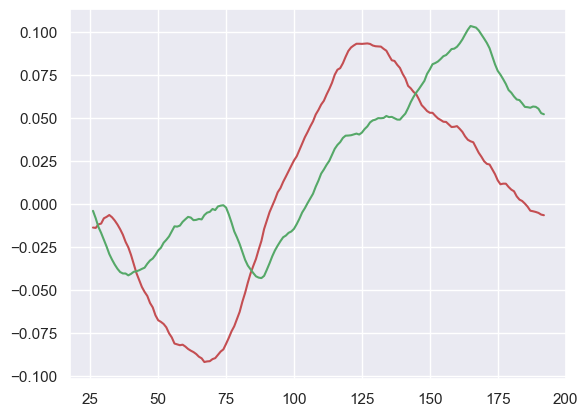

In [65]:
  proj_tk = np.mean(proj_crtk, axis=(0, 1))
  proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
  plt.plot(proj_tk[:, 0], color='r')
  plt.plot(proj_tk[:, 1], color='g')

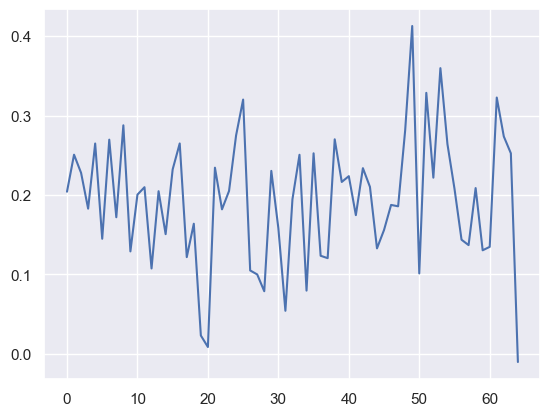

In [50]:
out_rtk = np.reshape(filt_rt_n[:, n_idx] @ scalings, (R, T, K))

plt.plot(np.mean(out_rtk[:, :, 1].T, 0));

In [186]:
from admice.ldaproj import project_lda_pufftone_parallel_samples
proj_crtk = project_lda_pufftone_parallel_samples(sess_ctrl[0], filt_strat_fit, filt_strat_project, samp_strat, 
  lda_mode = "separate", seed = 1, n_samples = 10)

### v3 run:


In [20]:
# run on all ctrl mice
from admice.ldaproj import multimouse_pipeline_project_lda_pufftone 

n_samples = 100
res_ctrl = multimouse_pipeline_project_lda_pufftone(sess_ctrl, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = n_samples)
res_young = multimouse_pipeline_project_lda_pufftone(sess_young, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = n_samples)
res_old = multimouse_pipeline_project_lda_pufftone(sess_old, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = n_samples)


(pid=36471) control 0 / 7: id 27 0:   0%|          | 0/700 [00:00<?, ?it/s]

(pid=36797) young_3xtg 0 / 5: id 18 0:   0%|          | 0/500 [00:00<?, ?it/s]

(pid=36968) old_3xtg 0 / 5: id 28 0:   0%|          | 0/500 [00:00<?, ?it/s]

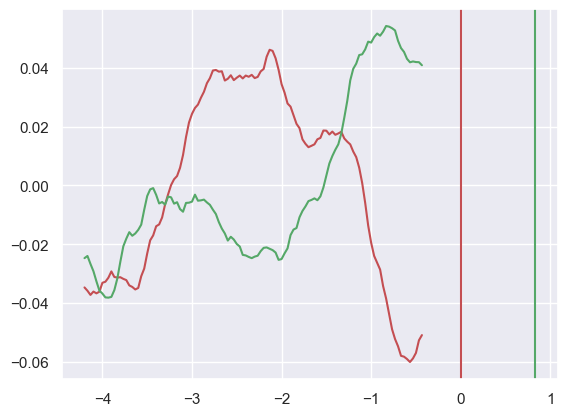

In [24]:
proj_tk, time_vec = res_old.get_grand_avg_tk()
rel_puff_time = (sess_old[0].puff_ind - sess_old[0].tone_ind) / sess_old[0].fps

offset = -(filt_strat_project.window_width_post + filt_strat_project.window_buffer_post) / sess_ctrl[0].fps

tone_ind = sess_ctrl[0].tone_ind
proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(time_vec + offset, proj_tk[:, 0], color='r')
plt.plot(time_vec + offset, proj_tk[:, 1], color='g')
plt.axvline(0, color='r')
plt.axvline(rel_puff_time, color='g')

In [80]:
kkfrom admice.eventlda import range_back_n, range_start_n
ic(range_start_n(148 + 2, 23))
ic(range_back_n(148 - 2, 23))

⚡ range_start_n(148 + 2, 23): ndarray, shape=(23,), dtype=float64, min=150.0, max=172.0
⚡ range_back_n(148 - 2, 23): ndarray, shape=(23,), dtype=float64, min=124.0, max=146.0


array([124., 125., ..., 145., 146.])

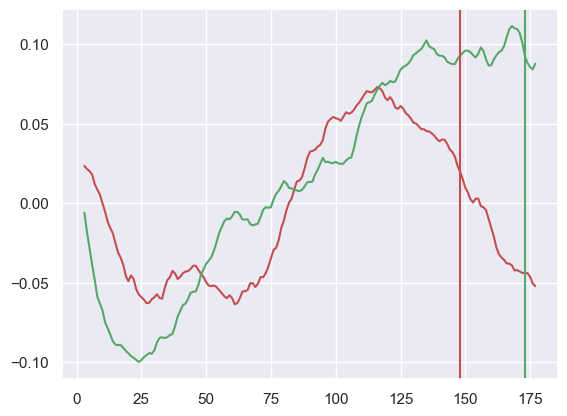

In [81]:
sess_ind = 0
proj_tk = np.mean(res_ctrl.proj_s_crtk[0], axis=(0, 1))
proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(proj_tk[:, 0], color='r')
plt.plot(proj_tk[:, 1], color='g')

plt.axvline(sess_ctrl[sess_ind].tone_ind, color='r')
plt.axvline(sess_ctrl[sess_ind].puff_ind, color='g')

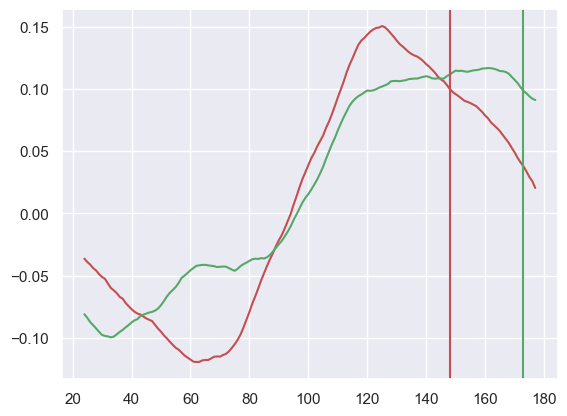

In [ ]:
sess_ind = 0
proj_tk = np.mean(res_ctrl.proj_s_crtk[0], axis=(0, 1))
proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(proj_tk[:, 0], color='r')
plt.plot(proj_tk[:, 1], color='g')

plt.axvline(sess_ctrl[sess_ind].tone_ind, color='r')
plt.axvline(sess_ctrl[sess_ind].puff_ind, color='g')

In [72]:
proj_tk

array([[nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan]])

In [10]:
res_avg = res_ctrl.averaged(over_samples=True, over_trials=True)
proj_s = res_avg.proj_s_crtk
align_inds = res_avg.align_inds

In [22]:
from admice.ldaproj import align_and_stack_axis2
out, ind = align_and_stack_axis2(proj_s, align_inds)

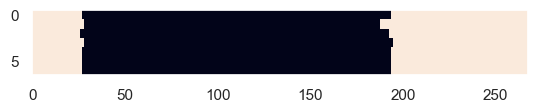

In [23]:
plt.imshow(np.isnan(np.squeeze(out)[:, :, 0]), interpolation='none')
ax = plt.gca()
ax.set_aspect(5)
ax.grid(False)

⚡ proj_stk: ndarray, shape=(7, 268, 2), dtype=float64, min=nan, max=nan


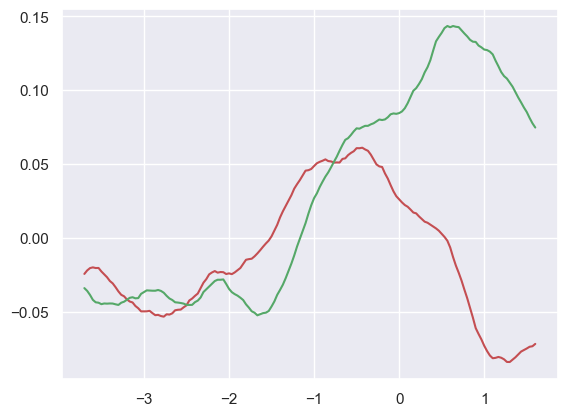

In [48]:
proj_scrtk, time_vec, aligned_tone_ind = res_ctrl.averaged(over_samples=True, over_trials=True).get_time_aligned_proj()
proj_stk = np.squeeze(proj_scrtk, axis=(1, 2))
ic(proj_stk);

offset = (filt_strat_project.window_width_post + filt_strat_project.window_buffer_post) / sess.fps

proj_tk = np.mean(proj_stk, axis=0)
proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(time_vec + offset, proj_tk[:, 0], color='r')
plt.plot(time_vec + offset, proj_tk[:, 1], color='g')
# plt.axvline(aligned_tone_ind, color='r')
# plt.axvline(puff_ind, color='g')

In [43]:
aligned_tone_ind

149

(np.float64(-0.04780276421215188),
 np.float64(0.0534536704118529),
 np.float64(-0.04571314842333698),
 np.float64(0.13407254076032882))

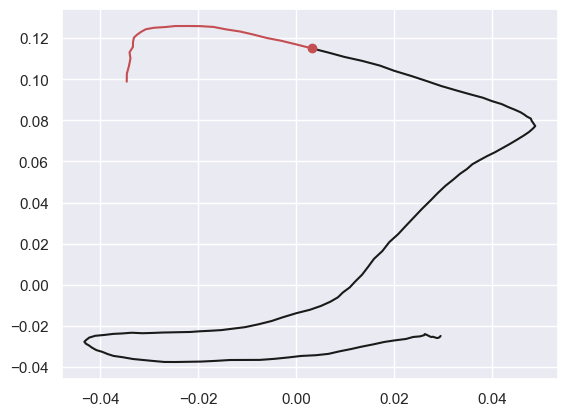

In [89]:
offset = filt_strat_project.window_width_post + filt_strat_project.window_buffer_post
offset = 0
start_ind = int(tone_ind - offset - sess.fps // 2)
start_ind = 0 

proj_scrtk, time_vec, aligned_tone_ind = res_ctrl.averaged(over_samples=True, over_trials=True).get_time_aligned_proj()
proj_stk = np.squeeze(proj_scrtk, axis=(1, 2))

tone_ind = aligned_tone_ind - offset
puff_ind = tone_ind + sess.puff_ind - sess.tone_ind


S = proj_stk.shape[0]
fig, ax = plt.subplots(1, 1)
# for s in range(S):
proj_tk = np.mean(proj_stk, axis=0)
# proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
# plt.plot(proj_tk[:, 0], color='r')
# plt.plot(proj_tk[:, 1], color='g')
ax.plot(proj_tk[start_ind, 0], proj_tk[start_ind, 1], 'o', color='k')
ax.plot(proj_tk[start_ind:tone_ind+1, 0], proj_tk[start_ind:tone_ind+1, 1], color='k')
ax.plot(proj_tk[tone_ind, 0], proj_tk[tone_ind, 1], marker='o', color='r')
ax.plot(proj_tk[tone_ind:puff_ind+1, 0], proj_tk[tone_ind:puff_ind+1, 1], color='r')
ax.plot(proj_tk[puff_ind:, 0], proj_tk[puff_ind:, 1], color='g')

ax.axis("tight")
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
# ax.set_aspect('equal', 'box')

In [ ]:
proj_tk[tone_ind]

In [172]:
lda.rotations_

AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'rotations_'

In [174]:
lda.coef_.shape

(3, 50)

### v4: non-cross validatated, LDA on whole trial epochs


In [24]:
from admice.eventlda import FilteringStrategy, NeuronSamplingStrategy

filt_strat_fit = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23, window_buffer_pre = 4, reduce_mode_pre = "mean", 
  window_width_post = 4, window_buffer_post = 0, reduce_mode_post = "mean")
filt_strat_project = filt_strat_fit
samp_strat = NeuronSamplingStrategy(mode="random", n_neurons = 50)

In [56]:
from admice.ldaproj import project_wholetrial_lda_pufftone_parallel_samples

n_samples = 100
sess_ind = 0
proj_crtk = project_wholetrial_lda_pufftone_parallel_samples(sess_ctrl[sess_ind], 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = n_samples, parallel=False)

⚡ proj_crtk.shape: (100, 65, 266, 2)


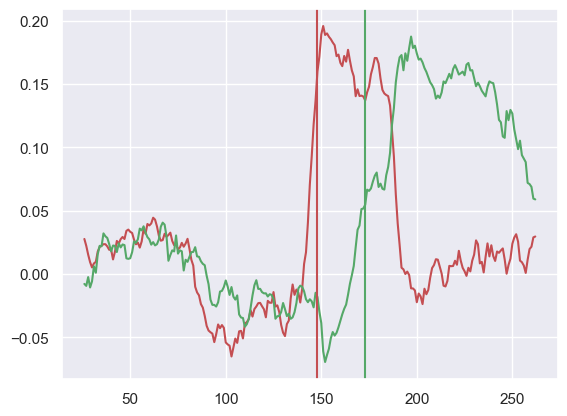

In [57]:
ic(proj_crtk.shape)
proj_tk = np.mean(proj_crtk, axis=(0, 1))

proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(proj_tk[:, 0], color='r')
plt.plot(proj_tk[:, 1], color='g')

plt.axvline(sess_ctrl[sess_ind].tone_ind, color='r')
plt.axvline(sess_ctrl[sess_ind].puff_ind, color='g')

In [192]:
# run on all ctrl mice
from admice.ldaproj import multimouse_pipeline_project_wholetrial_lda_pufftone 

n_samples = 100
res_ctrl = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_ctrl, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = n_samples)
res_young = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_young, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = n_samples)
res_old = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_old, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = n_samples)


(pid=97298) control 0 / 7: id 27 0:   0%|          | 0/700 [00:00<?, ?it/s]

(pid=97548) young_3xtg 0 / 5: id 18 0:   0%|          | 0/500 [00:00<?, ?it/s]

(pid=97674) old_3xtg 0 / 5: id 28 0:   0%|          | 0/500 [00:00<?, ?it/s]

/Users/djoshea/Dropbox/Dlab/Ted Ho AD Mouse Project/tedho_ad_mice/admice/ldaproj.py:668: RuntimeWarning: Mean of empty slice
  proj_s_crtk = [mean(a_crtk, axis=tuple(axes_avg), keepdims=True) for a_crtk in self.proj_s_crtk]


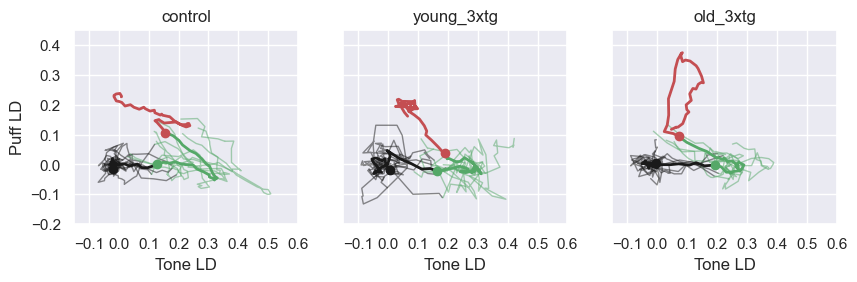

In [193]:
import matplotlib.ticker as ticker

from admice.dataload import Session
from admice.ldaproj import LDAProjResults


def plot_traj(mice: list[Session], res: LDAProjResults, ax, show_mean: bool = True, show_indiv: bool = False):
  sess = mice[0]
  offset = -filt_strat_project.window_width_post - filt_strat_project.window_buffer_post - 1

  tone_ind = sess.tone_ind + offset
  start_ind = tone_ind - sess.fps
  puff_ind = sess.puff_ind + offset


  if show_indiv:
    alpha_indiv = 0.5
    lw_indiv = 1
    proj_stk, time_vec = res.get_avg_stk(omitnan=True)
    proj_stk -= np.nanmean(proj_stk[:, start_ind:tone_ind, :], axis=1, keepdims=True)
    end_ind = min(proj_stk.shape[0], puff_ind + int(1.5 * sess.fps))
    S = len(mice)
    
    for s in range(S):
      ax.plot(*proj_stk[s, start_ind:tone_ind+1, :].T, color='k', alpha=alpha_indiv, linewidth=lw_indiv)
      ax.plot(*proj_stk[s, tone_ind:puff_ind+1, :].T, color='g', alpha=alpha_indiv, linewidth=lw_indiv)
      ax.plot(*proj_stk[s, puff_ind:end_ind, :].T, color='r', alpha=alpha_indiv, linewidth=lw_indiv)

  if show_mean:
    lw_mean = 2
    proj_tk, time_vec = res.get_grand_avg_tk(omitnan=True)
    proj_tk -= np.nanmean(proj_tk[start_ind:tone_ind], axis=0, keepdims=True)
    end_ind = min(proj_tk.shape[0], puff_ind + int(1.5 * sess.fps))
    
    ax.plot(*proj_tk[start_ind:tone_ind+1, :].T, color='k', linewidth=lw_mean)
    ax.plot(*proj_tk[tone_ind:puff_ind+1, :].T, color='g', linewidth=lw_mean)
    ax.plot(*proj_tk[puff_ind:end_ind, :].T, color='r', linewidth=lw_mean)

    ax.plot(*proj_tk[start_ind, :], marker='o', color='k')
    ax.plot(*proj_tk[tone_ind, :], marker='o', color='g')
    ax.plot(*proj_tk[puff_ind, :], marker='o', color='r')


  ax.set_title(sess.group)
  ax.set_aspect(1)

fig, ax = plt.subplots(1, 3, figsize=np.array((25, 8)) / 2.54, sharex=True, sharey=True)
show_indiv = True
plot_traj(sess_ctrl, res_ctrl, ax[0], show_indiv=show_indiv)
ax[0].set_ylabel('Puff LD')
ax[0].set_xlabel('Tone LD')

plot_traj(sess_young, res_young, ax[1], show_indiv=show_indiv)
ax[1].set_xlabel('Tone LD')

plot_traj(sess_old, res_old, ax[2], show_indiv=show_indiv)
ax[2].set_xlabel('Tone LD');

ax[0].set_xlim([-0.15, 0.6]);
ax[0].set_ylim([-0.2, 0.45]);
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

# plt.savefig('lda_trajectories.pdf', facecolor='w')
  

Text(0.5, 1.0, 'control')

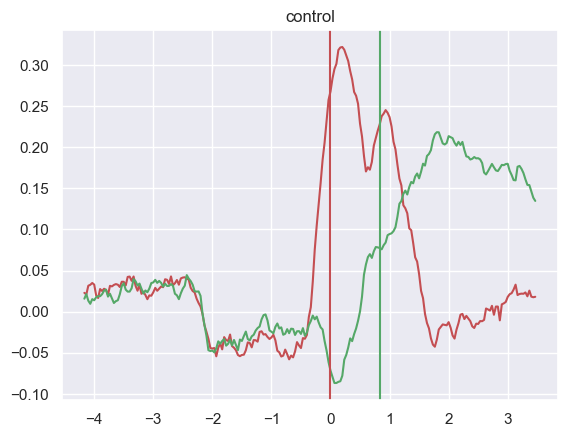

In [85]:
proj_tk, time_vec = res_ctrl.get_grand_avg_tk()
sess = sess_ctrl[0]
rel_puff_time = (sess.puff_ind - sess.tone_ind) / sess.fps

offset = -(filt_strat_project.window_width_post + filt_strat_project.window_buffer_post) / sess.fps

tone_ind = sess.tone_ind
proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(time_vec + offset, proj_tk[:, 0], color='r')
plt.plot(time_vec + offset, proj_tk[:, 1], color='g')
plt.axvline(0, color='r')
plt.axvline(rel_puff_time, color='g')
plt.title(sess.group)

Text(0.5, 1.0, 'young_3xtg')

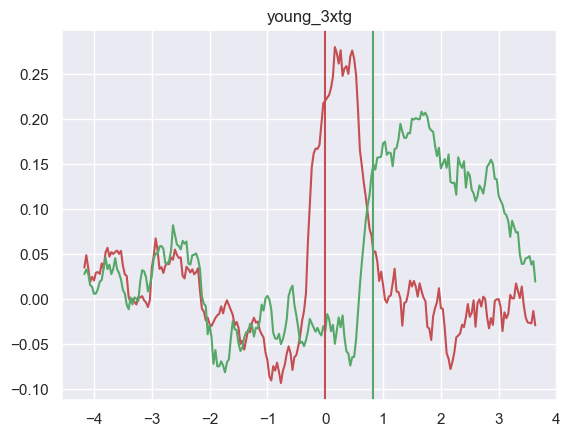

In [86]:
proj_tk, time_vec = res_young.get_grand_avg_tk()
sess = sess_young[0]
rel_puff_time = (sess.puff_ind - sess.tone_ind) / sess.fps

offset = -(filt_strat_project.window_width_post + filt_strat_project.window_buffer_post) / sess.fps

tone_ind = sess.tone_ind
proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(time_vec + offset, proj_tk[:, 0], color='r')
plt.plot(time_vec + offset, proj_tk[:, 1], color='g')
plt.axvline(0, color='r')
plt.axvline(rel_puff_time, color='g')
plt.title(sess.group)

Text(0.5, 1.0, 'old_3xtg')

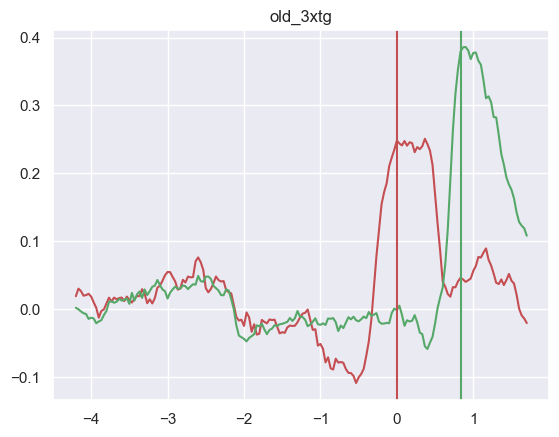

In [87]:
proj_tk, time_vec = res_old.get_grand_avg_tk(omitnan=True)
sess = sess_old[0]
rel_puff_time = (sess.puff_ind - sess.tone_ind) / sess.fps

offset = -(filt_strat_project.window_width_post + filt_strat_project.window_buffer_post) / sess.fps

tone_ind = sess.tone_ind
proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(time_vec + offset, proj_tk[:, 0], color='r')
plt.plot(time_vec + offset, proj_tk[:, 1], color='g')
plt.axvline(0, color='r')
plt.axvline(rel_puff_time, color='g')
plt.title(sess.group)

In [99]:
np.ones((2, 3, 4, 5)).T.shape

(5, 4, 3, 2)

In [98]:
a, b = *proj_tk[5:, :]

SyntaxError: can't use starred expression here (3012421166.py, line 1)

In [108]:
def fn(a, b):
  ic(a.shape)
  ic(b.shape)

v = np.ones((10, 2))
fn(*v[:5, :].T)

⚡ a.shape: (5,)
⚡ b.shape: (5,)


/Users/djoshea/Dropbox/Dlab/Ted Ho AD Mouse Project/tedho_ad_mice/admice/ldaproj.py:590: RuntimeWarning: Mean of empty slice
  proj_scrtk, time_vec, aligned_tone_ind = self.averaged(


Text(0.5, 0, 'Tone LD')

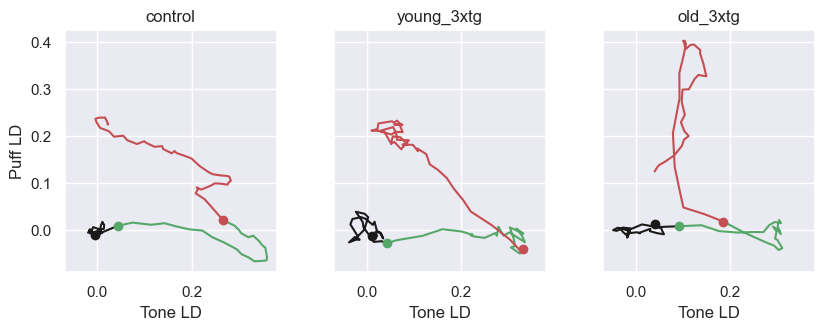

In [141]:
from admice.dataload import Session
from admice.ldaproj import LDAProjResults

def plot_traj(mice: list[Session], res: LDAProjResults, ax):
  proj_tk, time_vec = res.get_grand_avg_tk(omitnan=True)

  sess = mice[0]
  offset = -filt_strat_project.window_width_post - filt_strat_project.window_buffer_post - 1

  tone_ind = sess.tone_ind + offset
  start_ind = tone_ind - sess.fps
  puff_ind = sess.puff_ind + offset
  end_ind = min(proj_tk.shape[0], puff_ind + int(1.5 * sess.fps))
  proj_tk -= np.nanmean(proj_tk[start_ind:tone_ind, :], axis=0)
  
  ax.plot(*proj_tk[start_ind:tone_ind+1, :].T, color='k')
  ax.plot(*proj_tk[tone_ind:puff_ind+1, :].T, color='g')
  ax.plot(*proj_tk[puff_ind:end_ind, :].T, color='r')

  ax.plot(*proj_tk[start_ind, :], marker='o', color='k')
  ax.plot(*proj_tk[tone_ind, :], marker='o', color='g')
  ax.plot(*proj_tk[puff_ind, :], marker='o', color='r')
  ax.set_title(sess.group)

  ax.set_aspect(1)

fig, ax = plt.subplots(1, 3, figsize=np.array((25, 8)) / 2.54, sharex=True, sharey=True)
plot_traj(sess_ctrl, res_ctrl, ax[0])
ax[0].set_ylabel('Puff LD')
ax[0].set_xlabel('Tone LD')

plot_traj(sess_young, res_young, ax[1])
ax[1].set_xlabel('Tone LD')

plot_traj(sess_old, res_old, ax[2])
ax[2].set_xlabel('Tone LD')
  

### v5 : cross-validated on whole trial (ultimately used for figure)


In [25]:
from admice.eventlda import FilteringStrategy, NeuronSamplingStrategy

filt_strat_fit = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23, window_buffer_pre = 4, reduce_mode_pre = "mean", 
  window_width_post = 4, window_buffer_post = 0, reduce_mode_post = "mean")
filt_strat_project = filt_strat_fit
samp_strat = NeuronSamplingStrategy(mode="random", n_neurons = 50)

In [26]:
from admice.ldaproj import project_wholetrial_lda_pufftone_parallel_samples

n_samples = 100
sess_ind = 0
proj_crtk = project_wholetrial_lda_pufftone_parallel_samples(sess_ctrl[sess_ind], 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, samp_strat=samp_strat, n_samples = n_samples, lda_mode="separate_cv", parallel=True)

(pid=43016) Running samples 0:   0%|          | 0/100 [00:00<?, ?it/s]

⚡ proj_crtk.shape: (100, 65, 266, 2)


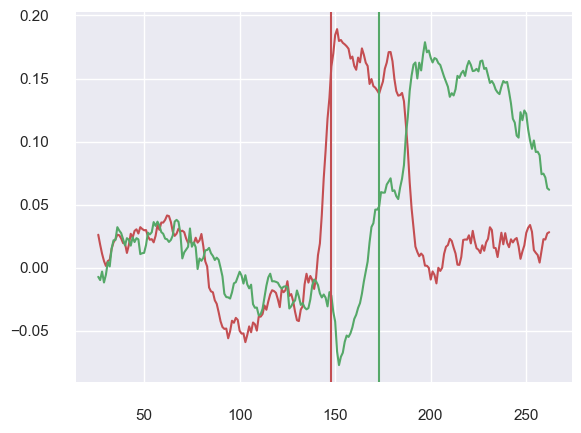

In [27]:
ic(proj_crtk.shape)
proj_tk = np.mean(proj_crtk, axis=(0, 1))

proj_tk -= np.nanmean(proj_tk[:tone_ind, :], axis=0)
plt.plot(proj_tk[:, 0], color='r')
plt.plot(proj_tk[:, 1], color='g')

plt.axvline(sess_ctrl[sess_ind].tone_ind, color='r')
plt.axvline(sess_ctrl[sess_ind].puff_ind, color='g')
sns.despine(offset=10)

In [28]:
# run on all ctrl mice
from admice.ldaproj import multimouse_pipeline_project_wholetrial_lda_pufftone 

n_samples = 100
lda_mode = "separate_cv"
res_ctrl = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_ctrl, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, lda_mode = lda_mode, samp_strat=samp_strat, n_samples = n_samples)
res_young = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_young, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, lda_mode = lda_mode, samp_strat=samp_strat, n_samples = n_samples)
res_old = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_old, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, lda_mode = lda_mode, samp_strat=samp_strat, n_samples = n_samples)


(pid=43243) control 0 / 7: id 27 0:   0%|          | 0/700 [00:01<?, ?it/s]

(pid=45022) young_3xtg 0 / 5: id 18 0:   0%|          | 0/500 [00:00<?, ?it/s]

(pid=46111) old_3xtg 0 / 5: id 28 0:   0%|          | 0/500 [00:00<?, ?it/s]

In [71]:
import pickle

analysis_root = os.path.join(data_root, "analysis")
if not os.path.exists(analysis_root):
  os.mkdir(analysis_root)

with open(os.path.join(analysis_root, 'lda_projection_wholetrial_separate_cv.pkl'), 'wb') as file:
  pickle.dump({'ctrl': res_ctrl, 'young': res_young, 'old': res_old}, file)

In [51]:
kimport matplotlib.ticker as ticker

from admice.dataload import Session
from admice.ldaproj import LDAProjResults

sns.set_style("ticks")

def plot_traj(mice: list[Session], res: LDAProjResults, ax, show_mean: bool = True, show_indiv: bool = False):
  sess = mice[0]
  offset = -filt_strat_project.window_width_post - filt_strat_project.window_buffer_post - 1

  tone_ind = sess.tone_ind + offset
  start_ind = tone_ind - sess.fps
  puff_ind = sess.puff_ind + offset


  if show_indiv:
    alpha_indiv = 0.4
    lw_indiv = 1
    proj_stk, time_vec = res.get_avg_stk(omitnan=True)
    proj_stk -= np.nanmean(proj_stk[:, start_ind:tone_ind, :], axis=1, keepdims=True)
    end_ind = min(proj_stk.shape[1], puff_ind + int(1.0 * sess.fps))
    S = len(mice)
    
    for s in range(S):
      ax.plot(*proj_stk[s, start_ind:tone_ind+1, :].T, color='k', alpha=alpha_indiv, linewidth=lw_indiv)
      ax.plot(*proj_stk[s, tone_ind:puff_ind+1, :].T, color='g', alpha=alpha_indiv, linewidth=lw_indiv)
      ax.plot(*proj_stk[s, puff_ind:end_ind, :].T, color='r', alpha=alpha_indiv*0.7, linewidth=lw_indiv)

  if show_mean:
    lw_mean = 2.5
    proj_tk, time_vec = res.get_grand_avg_tk(omitnan=True)
    proj_tk -= np.nanmean(proj_tk[start_ind:tone_ind], axis=0, keepdims=True)
    end_ind = min(proj_tk.shape[0], puff_ind + int(1.5 * sess.fps))
    
    ax.plot(*proj_tk[start_ind:tone_ind+1, :].T, color='k', linewidth=lw_mean)
    ax.plot(*proj_tk[tone_ind:puff_ind+1, :].T, color='g', linewidth=lw_mean)
    ax.plot(*proj_tk[puff_ind:end_ind, :].T, color='r', linewidth=lw_mean)

    ax.plot(*proj_tk[start_ind, :], marker='o', color='k')
    ax.plot(*proj_tk[tone_ind, :], marker='o', color='g')
    ax.plot(*proj_tk[puff_ind, :], marker='o', color='r')

  ax.set_title(sess.group)
  ax.set_aspect(1)

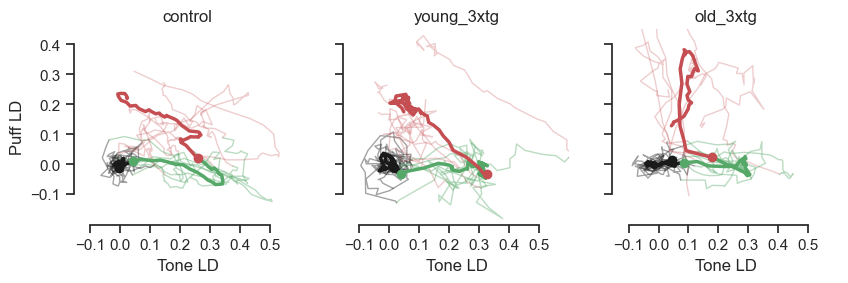

In [52]:
sns.set_style("ticks")
show_indiv = True
show_mean = True 
fig, ax = plt.subplots(1, 3, figsize=np.array((25, 8)) / 2.54, sharex=True, sharey=True)
plot_traj(sess_ctrl, res_ctrl, ax[0], show_indiv=show_indiv, show_mean=show_mean)
ax[0].set_ylabel('Puff LD')
ax[0].set_xlabel('Tone LD')

plot_traj(sess_young, res_young, ax[1], show_indiv=show_indiv, show_mean=show_mean)
ax[1].set_xlabel('Tone LD')

plot_traj(sess_old, res_old, ax[2], show_indiv=show_indiv, show_mean=show_mean)
ax[2].set_xlabel('Tone LD');

ax[0].set_xlim([-0.15, 0.6]);
ax[0].set_ylim([-0.2, 0.45]);
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

sns.despine(fig, offset=1, trim=True)

plt.savefig('../figures/lda_trajectories.pdf', facecolor='w')
  

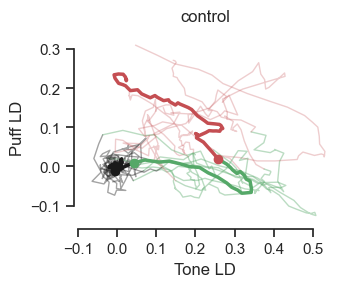

In [62]:
sns.set_style("ticks")
show_indiv = True
show_mean = True 
fig, ax = plt.subplots(1, 1, figsize=np.array((25/3, 8)) / 2.54, sharex=True, sharey=True)
plot_traj(sess_ctrl, res_ctrl, ax, show_indiv=show_indiv, show_mean=show_mean)
ax.set_ylabel('Puff LD')
ax.set_xlabel('Tone LD')

ax.set_xlim([-0.1, 0.55]);
ax.set_ylim([-0.15, 0.35]);
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

sns.despine(fig, offset=3, trim=True)

plt.savefig('../figures/lda_traj_ctrl.pdf', facecolor='w')
  

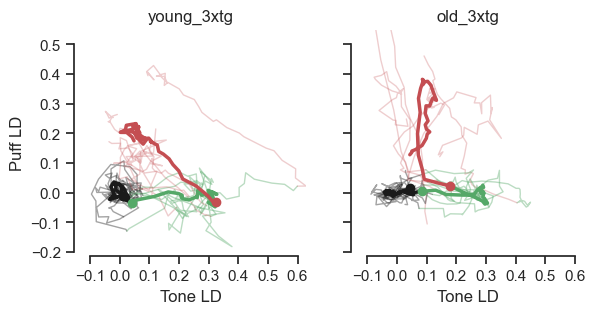

In [70]:
sns.set_style("ticks")
show_indiv = True
show_mean = True 

fig, ax = plt.subplots(1, 2, figsize=np.array((25.*2./3., 8)) / 2.54, sharex=True, sharey=True)
plot_traj(sess_young, res_young, ax[0], show_indiv=show_indiv, show_mean=show_mean)
ax[0].set_ylabel('Puff LD')
ax[0].set_xlabel('Tone LD')

plot_traj(sess_old, res_old, ax[1], show_indiv=show_indiv, show_mean=show_mean)
ax[1].set_xlabel('Tone LD');

ax[0].set_xlim([-0.15, 0.63]);
ax[0].set_ylim([-0.21, 0.55]);
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

sns.despine(fig, offset=1, trim=True)

plt.savefig('../figures/lda_traj_young_old.pdf', facecolor='w')
  

In [167]:
avg, tvec = res_ctrl.get_avg_stk()
np.nanmean(avg[:, 2:10, :], axis=1).shape

/var/folders/d1/sb1mvmvx4yd578kyyg2pm8zm0000gn/T/ipykernel_13198/3163119235.py:2: RuntimeWarning: Mean of empty slice
  np.nanmean(avg[:, 2:10, :], axis=1).shape


(7, 2)